# GIS-based Assessment of Utility-Scale Photovoltaic Potential
## Suedoststeiermark, Austria

This notebook presents a GIS-based analysis of solar photovoltaic (PV) potential for the Suedoststeiermark district in Austria. The methodology is adapted from:

> Benalcazar, P., Komorowska, A., and Kaminski, J. (2024). *A GIS-based method for assessing the economics of utility-scale photovoltaic systems*. Applied Energy, 353, 122044.

---

### Analysis Overview

1. **Land Eligibility Analysis** - Identify suitable areas by applying exclusion criteria
2. **Techno-Economic Assessment** - Calculate Levelized Cost of Electricity (LCOE)
3. **Potential Estimation** - Estimate installable capacity and energy generation

---

## 1. Setup and Configuration

In [1]:
# Add project root to path
import sys
from pathlib import Path

# Navigate to project root (one level up from notebooks/)
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Import configuration
from config import (
    STUDY_AREA_SHAPEFILE,
    REGION_MASK,
    MASTER_SUITABILITY,
    LCOE_RASTER,
    PVOUT_RAW,
    TARGET_CRS,
    RESOLUTION,
    MAX_SLOPE_DEGREES,
    BUFFER_DISTANCES,
    RESULTS_RASTERS_DIR,
)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Target CRS: {TARGET_CRS}")
print(f"Resolution: {RESOLUTION}m")

Project Root: c:\Studium\MASTER\KURSE\GIS_Analysetechniken_2\GIS_2_midterm
Target CRS: EPSG:32633
Resolution: 100m


In [2]:
# Import libraries
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import xy
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pyproj

# Set plot style
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

---

## 2. Study Area

The study area is **Suedoststeiermark**, a district in the Austrian state of Styria. It is located in southeastern Austria, bordering Slovenia.

In [3]:
# Load and display study area
study_area = gpd.read_file(STUDY_AREA_SHAPEFILE)
study_area = study_area.to_crs(TARGET_CRS)

# Calculate area
total_area_km2 = study_area.geometry.area.sum() / 1e6

print(f"Study Area: Suedoststeiermark")
print(f"Total Area: {total_area_km2:.2f} km²")
print(f"CRS: {study_area.crs}")

Study Area: Suedoststeiermark
Total Area: 985.06 km²
CRS: EPSG:32633


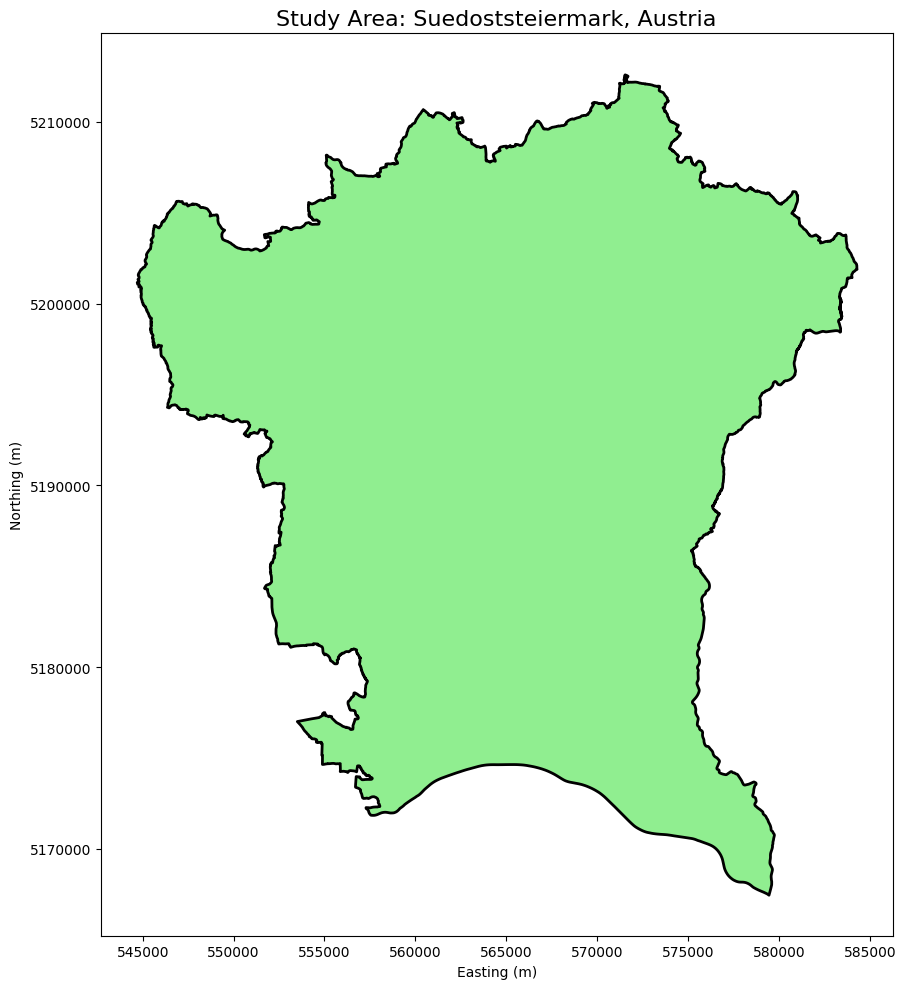

In [4]:
# Plot study area
fig, ax = plt.subplots(figsize=(10, 10))
study_area.plot(ax=ax, facecolor='lightgreen', edgecolor='black', linewidth=2)
ax.set_title('Study Area: Suedoststeiermark, Austria', fontsize=16)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.ticklabel_format(style='plain')
plt.tight_layout()
plt.show()

---

## 3. Exclusion Criteria

Areas unsuitable for utility-scale PV installations are excluded based on the following constraints:

| Constraint | Buffer Distance | Rationale |
|------------|-----------------|----------|
| Powerlines | 120 m | Safety distance |
| Streets | 100 m | Road setback |
| Railway | 100 m | Railway setback |
| Airport | 5000 m | Flight paths, noise |
| Urban Area | 500 m | Residential buffer |
| Industry | 500 m | Industrial zone buffer |
| Water Bodies | 0 m | Direct exclusion |
| Natura 2000 | 300 m | Protected area buffer |
| Forest | 0 m | Direct exclusion |
| Slope > 30° | - | Terrain constraint |

In [5]:
# Display buffer distances from config
print("Exclusion Buffer Distances:")
print("=" * 40)
for constraint, distance in BUFFER_DISTANCES.items():
    print(f"  {constraint:15} : {distance:>5} m")
print(f"  {'slope':15} : > {MAX_SLOPE_DEGREES}°")

Exclusion Buffer Distances:
  powerlines      :   120 m
  streets         :   100 m
  railway         :   100 m
  airport         :  5000 m
  urban_area      :   500 m
  industry        :   500 m
  water_bodies    :     0 m
  natura2000      :   300 m
  forest          :     0 m
  slope           : > 30°


---

## 4. Land Suitability Results

After applying all exclusion criteria, the remaining land is classified as suitable for PV installation.

In [6]:
# Load region mask and master suitability
with rasterio.open(REGION_MASK) as src:
    region_mask = src.read(1)
    transform = src.transform
    crs = src.crs

with rasterio.open(MASTER_SUITABILITY) as src:
    suitability = src.read(1)

# Calculate statistics
cell_area_km2 = (RESOLUTION * RESOLUTION) / 1e6  # 0.01 km² for 100m pixels

total_pixels = np.sum(region_mask == 1)
suitable_pixels = np.sum(suitability == 1)
excluded_pixels = total_pixels - suitable_pixels

total_area = total_pixels * cell_area_km2
suitable_area = suitable_pixels * cell_area_km2
excluded_area = excluded_pixels * cell_area_km2

suitable_pct = (suitable_pixels / total_pixels) * 100
excluded_pct = (excluded_pixels / total_pixels) * 100

print("Land Suitability Analysis Results")
print("=" * 45)
print(f"  Total Study Area:    {total_area:>10.2f} km² (100.00%)")
print(f"  Suitable Area:       {suitable_area:>10.2f} km² ({suitable_pct:>6.2f}%)")
print(f"  Excluded Area:       {excluded_area:>10.2f} km² ({excluded_pct:>6.2f}%)")

Land Suitability Analysis Results
  Total Study Area:        986.63 km² (100.00%)
  Suitable Area:           106.84 km² ( 10.83%)
  Excluded Area:           879.79 km² ( 89.17%)


In [7]:
# Helper function for lat/lon ticks
def get_latlon_ticks(transform, crs, width, height, num_ticks=5):
    """Generate tick values for x and y axes in Lat/Lon."""
    # Get pixel positions for ticks
    x_pixels = np.linspace(0, width-1, num_ticks)
    y_pixels = np.linspace(0, height-1, num_ticks)
    
    transformer = None
    if str(crs) != 'EPSG:4326':
        transformer = pyproj.Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)
    
    # Get lon values along x-axis (use middle row)
    lon_ticks = []
    mid_y = height // 2
    for x in x_pixels:
        lon, lat = xy(transform, mid_y, x)
        if transformer:
            lon, lat = transformer.transform(lon, lat)
        lon_ticks.append(lon)
    
    # Get lat values along y-axis (use middle column)
    lat_ticks = []
    mid_x = width // 2
    for y in y_pixels:
        lon, lat = xy(transform, y, mid_x)
        if transformer:
            lon, lat = transformer.transform(lon, lat)
        lat_ticks.append(lat)
    
    return np.array(lon_ticks), np.array(lat_ticks)

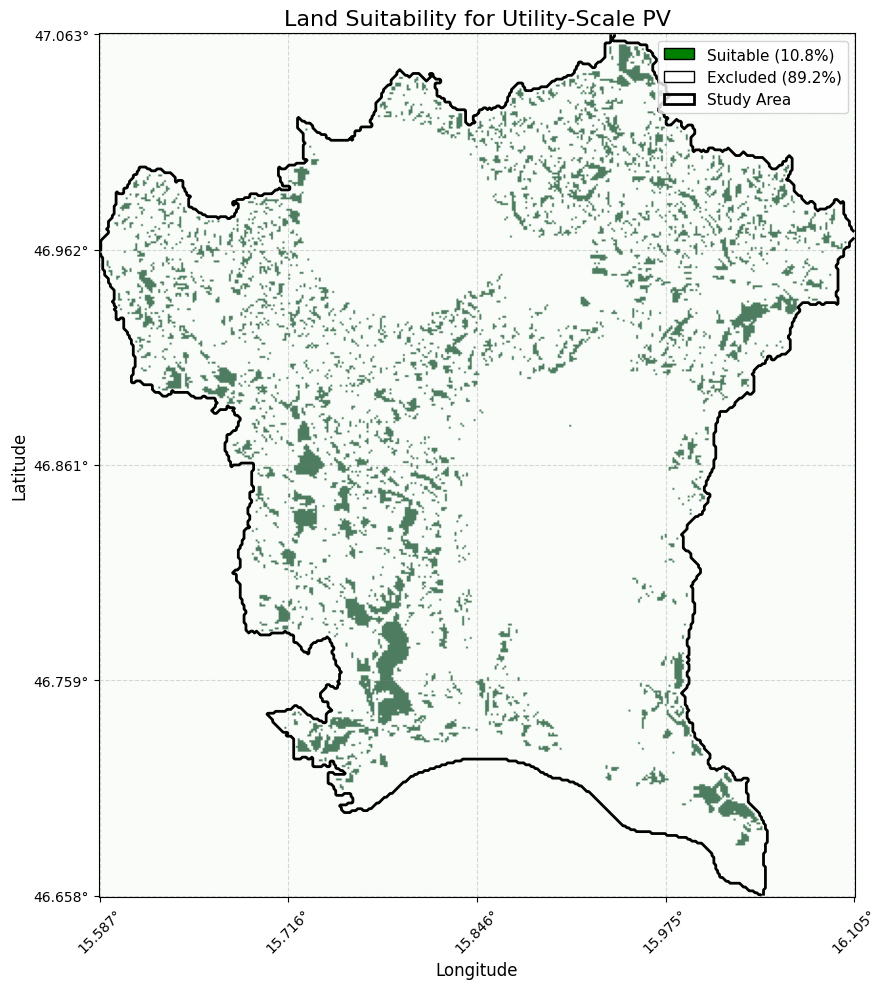

In [8]:
# Plot suitable vs excluded areas
height, width = suitability.shape
x_ticks, y_ticks = get_latlon_ticks(transform, crs, width, height)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot suitability (green = suitable)
suit_img = ax.imshow(suitability == 1, cmap='Greens', alpha=0.7, vmin=0, vmax=1)

# Add region boundary
ax.contour(region_mask, levels=[0.5], colors='black', linewidths=2)

# Axis settings
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xticks(np.linspace(0, width-1, len(x_ticks)))
ax.set_xticklabels([f"{lon:.3f}°" for lon in x_ticks], rotation=45)
ax.set_yticks(np.linspace(0, height-1, len(y_ticks)))
ax.set_yticklabels([f"{lat:.3f}°" for lat in y_ticks])
ax.grid(True, color='gray', linestyle='--', alpha=0.3)

# Title and legend
ax.set_title('Land Suitability for Utility-Scale PV', fontsize=16)
legend_handles = [
    Patch(facecolor='green', edgecolor='black', label=f'Suitable ({suitable_pct:.1f}%)'),
    Patch(facecolor='white', edgecolor='black', label=f'Excluded ({excluded_pct:.1f}%)'),
    Patch(facecolor='none', edgecolor='black', linewidth=2, label='Study Area')
]
ax.legend(handles=legend_handles, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

---

## 5. LCOE Analysis

The **Levelized Cost of Electricity (LCOE)** is calculated for each suitable pixel using the formula from Benalcazar et al. (2024):

$$
LCOE = \frac{(H + 0.5H) \cdot CRF + I_0 \cdot \theta}{E_{year}}
$$

Where:
- $H$ = CAPEX (545.6 €/kW)
- $CRF$ = Capital Recovery Factor
- $I_0$ = Initial investment (= H)
- $\theta$ = Annual O&M cost (1% of CAPEX)
- $E_{year}$ = Annual energy yield (kWh/kWp/year)

The Capital Recovery Factor is:

$$
CRF = \frac{i(1+i)^N}{(1+i)^N - 1}
$$

With discount rate $i$ = 5.92% and lifetime $N$ = 25 years.

In [9]:
# Techno-economic parameters
H = 545.6      # €/kW (CAPEX)
i = 0.0592     # 5.92% discount rate
N = 25         # lifetime in years
theta = 0.01   # 1% of I0 per year for O&M
I0 = H         # initial investment per kW

# Calculate CRF
def crf(i, N):
    """Capital Recovery Factor."""
    return i * (1 + i) ** N / ((1 + i) ** N - 1)

CRF = crf(i, N)

print("Techno-Economic Parameters")
print("=" * 40)
print(f"  CAPEX (H):           {H} €/kW")
print(f"  Discount Rate (i):   {i*100:.2f}%")
print(f"  Lifetime (N):        {N} years")
print(f"  O&M (theta):         {theta*100:.0f}% of CAPEX/year")
print(f"  CRF:                 {CRF:.6f}")

Techno-Economic Parameters
  CAPEX (H):           545.6 €/kW
  Discount Rate (i):   5.92%
  Lifetime (N):        25 years
  O&M (theta):         1% of CAPEX/year
  CRF:                 0.077633


In [10]:
# Load LCOE raster
with rasterio.open(LCOE_RASTER) as src:
    lcoe_data = src.read(1)
    lcoe_transform = src.transform

# Calculate LCOE statistics (only for eligible areas)
eligible = suitability == 1
lcoe_eligible = lcoe_data[eligible]
lcoe_eligible = lcoe_eligible[~np.isnan(lcoe_eligible)]  # Remove NaN values

print("LCOE Statistics (Eligible Areas)")
print("=" * 40)
print(f"  Minimum:  {np.min(lcoe_eligible)*100:.4f} €ct/kWh")
print(f"  Maximum:  {np.max(lcoe_eligible)*100:.4f} €ct/kWh")
print(f"  Mean:     {np.mean(lcoe_eligible)*100:.4f} €ct/kWh")
print(f"  Median:   {np.median(lcoe_eligible)*100:.4f} €ct/kWh")

LCOE Statistics (Eligible Areas)
  Minimum:  5.4196 €ct/kWh
  Maximum:  5.5570 €ct/kWh
  Mean:     5.4804 €ct/kWh
  Median:   5.4811 €ct/kWh


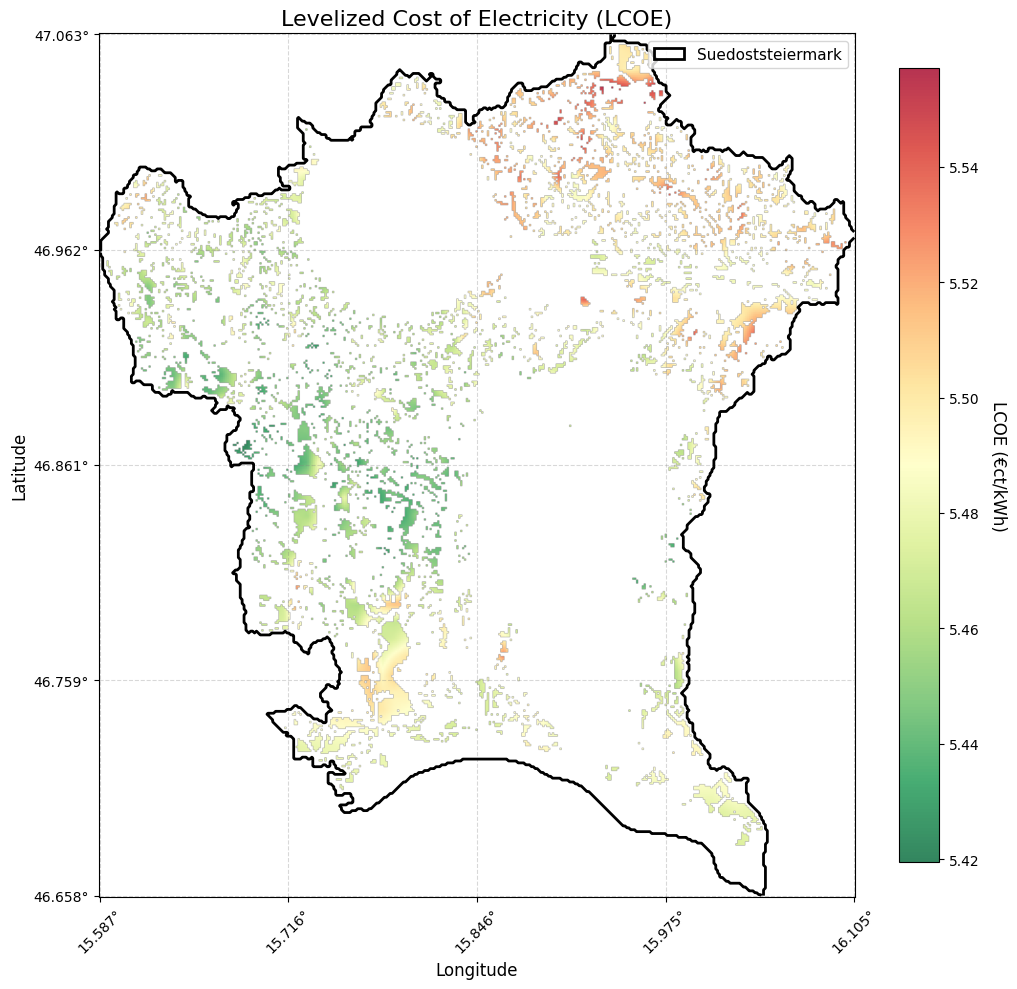

In [11]:
# Plot LCOE heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create masked array for visualization (hide non-eligible areas)
lcoe_masked = np.ma.masked_where(np.isnan(lcoe_data), lcoe_data)

# Plot LCOE
im = ax.imshow(lcoe_masked * 100, cmap='RdYlGn_r', alpha=0.8)  # Convert to cents
cbar = fig.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('LCOE (€ct/kWh)', rotation=270, labelpad=20, fontsize=12)

# Add region boundary
ax.contour(region_mask, levels=[0.5], colors='black', linewidths=2)

# Axis settings
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xticks(np.linspace(0, width-1, len(x_ticks)))
ax.set_xticklabels([f"{lon:.3f}°" for lon in x_ticks], rotation=45)
ax.set_yticks(np.linspace(0, height-1, len(y_ticks)))
ax.set_yticklabels([f"{lat:.3f}°" for lat in y_ticks])
ax.grid(True, color='gray', linestyle='--', alpha=0.3)

ax.set_title('Levelized Cost of Electricity (LCOE)', fontsize=16)

legend_handles = [
    Patch(facecolor='none', edgecolor='black', linewidth=2, label='Suedoststeiermark')
]
ax.legend(handles=legend_handles, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

---

## 6. Installable Capacity and Energy Potential

The installable capacity is estimated using land-use efficiency factors:
- **Conservative**: 35 MW/km²
- **Ambitious**: 50 MW/km²

In [12]:
# Load annual energy yield
E_year_path = RESULTS_RASTERS_DIR / "pvout_Eyear_aligned.tif"
with rasterio.open(E_year_path) as src:
    E_year = src.read(1)

# Calculate mean annual yield for eligible areas
E_year_mean = E_year[eligible].mean()

print(f"Mean Annual Yield: {E_year_mean:.2f} kWh/kWp/year")

Mean Annual Yield: 1258.89 kWh/kWp/year


In [13]:
# Calculate installable capacity and energy potential
cell_area_km2 = (RESOLUTION * RESOLUTION) / 1e6  # 0.01 km² for 100m pixels

# Land-use efficiency factors
lf_35 = 35.0  # MW/km² (conservative)
lf_50 = 50.0  # MW/km² (ambitious)

# Number of eligible cells
n_eligible = np.count_nonzero(eligible)
eligible_area_km2 = n_eligible * cell_area_km2

# Installable capacity
P_35_MW = eligible_area_km2 * lf_35
P_50_MW = eligible_area_km2 * lf_50

# Annual energy generation
E_35_GWh = (P_35_MW * 1000) * E_year_mean / 1e6  # GWh/year
E_50_GWh = (P_50_MW * 1000) * E_year_mean / 1e6  # GWh/year

print("Installable Capacity and Energy Potential")
print("=" * 50)
print(f"  Eligible Area:              {eligible_area_km2:.2f} km²")
print(f"  Mean Annual Yield:          {E_year_mean:.2f} kWh/kWp/year")
print()
print("  Conservative (35 MW/km²):")
print(f"    Installable Capacity:     {P_35_MW:.2f} MW")
print(f"    Annual Energy:            {E_35_GWh:.2f} GWh/year")
print()
print("  Ambitious (50 MW/km²):")
print(f"    Installable Capacity:     {P_50_MW:.2f} MW")
print(f"    Annual Energy:            {E_50_GWh:.2f} GWh/year")

Installable Capacity and Energy Potential
  Eligible Area:              106.84 km²
  Mean Annual Yield:          1258.89 kWh/kWp/year

  Conservative (35 MW/km²):
    Installable Capacity:     3739.40 MW
    Annual Energy:            4707.48 GWh/year

  Ambitious (50 MW/km²):
    Installable Capacity:     5342.00 MW
    Annual Energy:            6724.97 GWh/year


---

## 7. Summary

### Key Findings

In [14]:
# Summary table
print("╔" + "═"*58 + "╗")
print("║" + " SUMMARY: PV Potential in Suedoststeiermark ".center(58) + "║")
print("╠" + "═"*58 + "╣")
print(f"║  Study Area:                    {total_area:>10.2f} km²          ║")
print(f"║  Suitable Area:                 {suitable_area:>10.2f} km² ({suitable_pct:.1f}%)   ║")
print(f"║  Excluded Area:                 {excluded_area:>10.2f} km² ({excluded_pct:.1f}%)   ║")
print("╠" + "═"*58 + "╣")
print(f"║  Mean LCOE:                     {np.mean(lcoe_eligible)*100:>10.2f} €ct/kWh      ║")
print(f"║  Mean Annual Yield:             {E_year_mean:>10.2f} kWh/kWp/yr   ║")
print("╠" + "═"*58 + "╣")
print(f"║  Installable Capacity (35 MW/km²): {P_35_MW:>7.0f} MW            ║")
print(f"║  Installable Capacity (50 MW/km²): {P_50_MW:>7.0f} MW            ║")
print(f"║  Annual Energy (35 MW/km²):        {E_35_GWh:>7.0f} GWh/yr        ║")
print(f"║  Annual Energy (50 MW/km²):        {E_50_GWh:>7.0f} GWh/yr        ║")
print("╚" + "═"*58 + "╝")

╔══════════════════════════════════════════════════════════╗
║        SUMMARY: PV Potential in Suedoststeiermark        ║
╠══════════════════════════════════════════════════════════╣
║  Study Area:                        986.63 km²          ║
║  Suitable Area:                     106.84 km² (10.8%)   ║
║  Excluded Area:                     879.79 km² (89.2%)   ║
╠══════════════════════════════════════════════════════════╣
║  Mean LCOE:                           5.48 €ct/kWh      ║
║  Mean Annual Yield:                1258.89 kWh/kWp/yr   ║
╠══════════════════════════════════════════════════════════╣
║  Installable Capacity (35 MW/km²):    3739 MW            ║
║  Installable Capacity (50 MW/km²):    5342 MW            ║
║  Annual Energy (35 MW/km²):           4707 GWh/yr        ║
║  Annual Energy (50 MW/km²):           6725 GWh/yr        ║
╚══════════════════════════════════════════════════════════╝


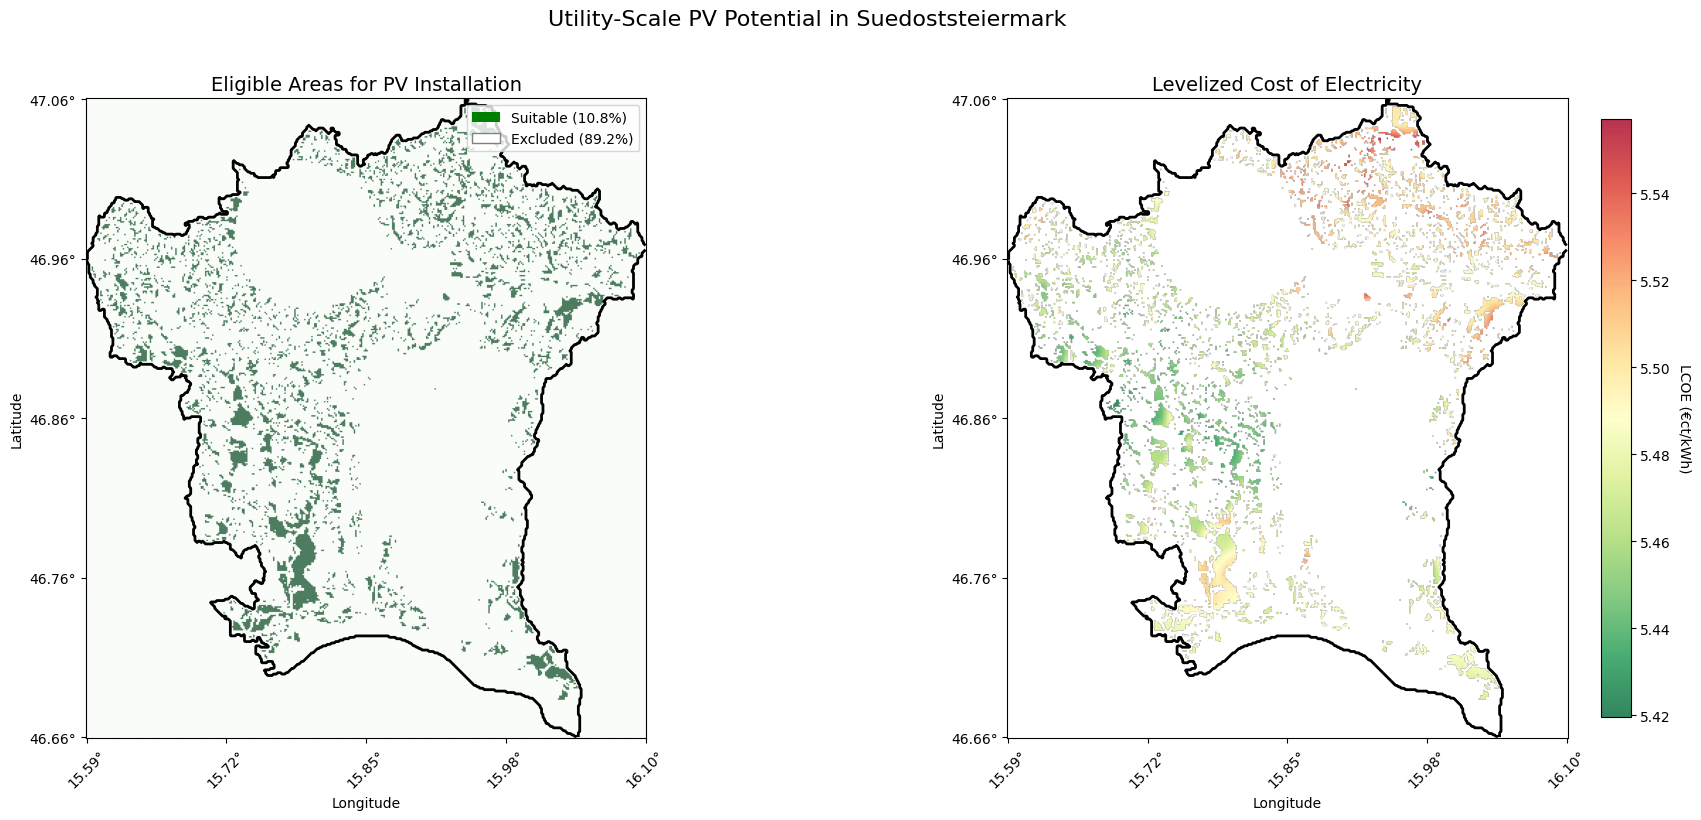

In [15]:
# Final visualization - Combined plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Get fresh tick values with exactly 5 ticks
num_ticks = 5
x_ticks_plot, y_ticks_plot = get_latlon_ticks(transform, crs, width, height, num_ticks)

# Left: Eligible areas
ax1 = axes[0]
ax1.imshow(suitability == 1, cmap='Greens', alpha=0.7)
ax1.contour(region_mask, levels=[0.5], colors='black', linewidths=2)
ax1.set_title('Eligible Areas for PV Installation', fontsize=14)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_xticks(np.linspace(0, width-1, num_ticks))
ax1.set_xticklabels([f"{lon:.2f}°" for lon in x_ticks_plot], rotation=45)
ax1.set_yticks(np.linspace(0, height-1, num_ticks))
ax1.set_yticklabels([f"{lat:.2f}°" for lat in y_ticks_plot])
legend1 = [
    Patch(facecolor='green', label=f'Suitable ({suitable_pct:.1f}%)'),
    Patch(facecolor='white', edgecolor='gray', label=f'Excluded ({excluded_pct:.1f}%)')
]
ax1.legend(handles=legend1, loc='upper right')

# Right: LCOE
ax2 = axes[1]
im2 = ax2.imshow(lcoe_masked * 100, cmap='RdYlGn_r', alpha=0.8)
ax2.contour(region_mask, levels=[0.5], colors='black', linewidths=2)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.036, pad=0.04)
cbar2.set_label('LCOE (€ct/kWh)', rotation=270, labelpad=15)
ax2.set_title('Levelized Cost of Electricity', fontsize=14)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_xticks(np.linspace(0, width-1, num_ticks))
ax2.set_xticklabels([f"{lon:.2f}°" for lon in x_ticks_plot], rotation=45)
ax2.set_yticks(np.linspace(0, height-1, num_ticks))
ax2.set_yticklabels([f"{lat:.2f}°" for lat in y_ticks_plot])

plt.suptitle('Utility-Scale PV Potential in Suedoststeiermark', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

---

## References

1. Benalcazar, P., Komorowska, A., and Kaminski, J. (2024). A GIS-based method for assessing the economics of utility-scale photovoltaic systems. *Applied Energy*, 353, 122044. https://doi.org/10.1016/j.apenergy.2023.122044

---

*Notebook generated for GIS Analysetechniken 2 - Midterm Project*